This notebook explores the set up and formulation of an edge machine learning model for predicting active power in a wind turbine. 

The first step is to import the dependencies. 

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext memory_profiler
%matplotlib notebook

We then load the data stored as parquet files for a particular wind turbine into a Pandas dataframe. The `dirname` has to be changed to the location where the parquet files are stored in the local directory.  

In [7]:
## LOAD SOME DATA

NDAYS = 14 # == number of files

dirname = '/home/seshu/work/workspace/2020/more/sw/data/raw_anonymized/BEBUE/BEBUEE03/'
filenames = os.listdir(dirname)
filenames.sort() #make sure they are ordered
# print(filenames)
X = pd.read_parquet(os.path.join(dirname,filenames[0]))#,filters=[('datetime','>','2019-03-01'),('datetime','<','2019-04-01')])
for n in range(1,NDAYS):
    X = X.append(pd.read_parquet(os.path.join(dirname,filenames[n])),ignore_index=True)
X.head()

,date,mac_code,parc_code,ComEolToPoste_BEBUEE03_Active_Power_Valeur,ComEolToPoste_BEBUEE03_Active_Power_ValeurText,ComEolToPoste_BEBUEE03_Active_Power_OpcQuality,Convert_BEBUEE03_CosPhi_Valeur,Convert_BEBUEE03_CosPhi_ValeurText,Convert_BEBUEE03_CosPhi_OpcQuality,Generatrice_BEBUEE03_GenSpeed_Valeur,...,Turbine_BEBUEE03_PosReactenergy_OpcQuality,Turbine_BEBUEE03_TotalActivePowerGen0_Valeur,Turbine_BEBUEE03_TotalActivePowerGen0_ValeurText,Turbine_BEBUEE03_TotalActivePowerGen0_OpcQuality,GestionAlm_BEBUEE03_Defaut_Valeur,GestionAlm_BEBUEE03_Defaut_ValeurText,GestionAlm_BEBUEE03_Defaut_OpcQuality,GestionAlm_BEBUEE03_NumAlarme_Valeur,GestionAlm_BEBUEE03_NumAlarme_ValeurText,GestionAlm_BEBUEE03_NumAlarme_OpcQuality
0,2018-04-01 00:00:00.000,BEBUEE03,BEBUE,31.799999,None,192.0,1.0,None,192.0,997.5,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN
1,2018-04-01 00:00:00.372,BEBUEE03,BEBUE,28.700001,None,192.0,NaN,None,NaN,996.5,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN
2,2018-04-01 00:00:00.373,BEBUEE03,BEBUE,NaN,None,NaN,NaN,None,NaN,NaN,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN
3,2018-04-01 00:00:00.545,BEBUEE03,BEBUE,NaN,None,NaN,NaN,None,NaN,NaN,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN
4,2018-04-01 00:00:01.388,BEBUEE03,BEBUE,NaN,None,NaN,NaN,None,NaN,NaN,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN


We then do some high level statistics on the loaded data. 

In [8]:
## Size and time period
print('Num records: %d' % X.shape[0])
print('Num columns: %d' % X.shape[1])
print('Minimum time: %s' % X['date'].min())
print('Maximum time: %s' % X['date'].max())
print('Time step: %.3f sec +- %.3f sec' % (X['date'].diff().dt.total_seconds().mean(),X['date'].diff().dt.total_seconds().std()))


Num records: 1229687
Num columns: 141
Minimum time: 2018-04-01 00:00:00
Maximum time: 2018-04-14 23:59:57.752000
Time step: 0.984 sec +- 0.731 sec


Data analysis to see missing data from the sensors. 

<IPython.core.display.Javascript object>


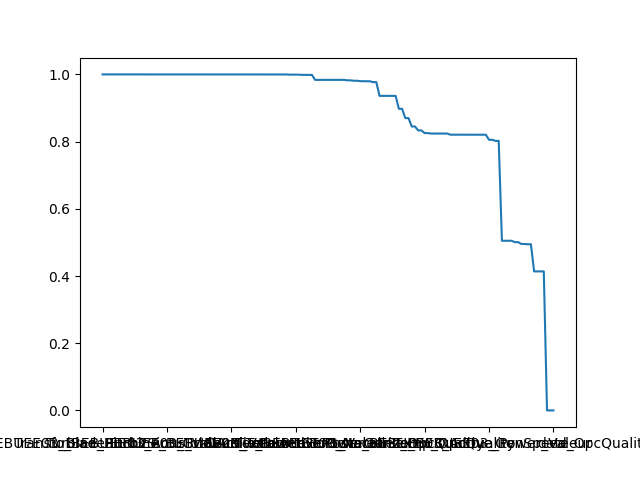

<AxesSubplot:>

In [9]:
## Some missing data analysis
plt.close(-1)
plt.figure(-1)
(X.isna().sum(axis=0)/X.shape[0]).sort_values(ascending=False).plot()

In [10]:
## Let's focus on columns without too many missing data 
MaxMissingRatio = 0.9
columns_to_keep = X.isna().sum(axis=0)[X.isna().sum(axis=0)/X.shape[0] <= MaxMissingRatio].index.values.tolist()

## Quality columns analysis
columns_to_keep_quality = [c for c in columns_to_keep if c.endswith('OpcQuality')]
print('Unique values in quality columns:')
for c in columns_to_keep_quality:
    print('%s: %r' % (c,X[c].unique()))
    
## Remove quality columns from columns_to_keep 
[ columns_to_keep.remove(el) for el in columns_to_keep_quality]
## Remove metadata columns from columns_to_keep
columns_to_keep.remove('mac_code')
columns_to_keep.remove('parc_code')
print(columns_to_keep)

Unique values in quality columns:
ComEolToPoste_BEBUEE03_Active_Power_OpcQuality: array([192.,  nan])
Convert_BEBUEE03_CosPhi_OpcQuality: array([192.,  nan])
Generatrice_BEBUEE03_GenSpeed_OpcQuality: array([192.,  nan])
Nacelle_BEBUEE03_AbsWindDirect_OpcQuality: array([192.,  nan])
Nacelle_BEBUEE03_AbsWindDirectCosinus_OpcQuality: array([192.,  nan])
Nacelle_BEBUEE03_AbsWindDirectSinus_OpcQuality: array([192.,  nan])
Nacelle_BEBUEE03_HydPres_OpcQuality: array([192.,  nan])
Nacelle_BEBUEE03_NacelleAngleCosinus_OpcQuality: array([192.,  nan])
Nacelle_BEBUEE03_NacelleAngleSinus_OpcQuality: array([192.,  nan])
Nacelle_BEBUEE03_Windspeed_OpcQuality: array([192.,  nan])
Rotor_BEBUEE03_BladePitch1_OpcQuality: array([192.,  nan])
Rotor_BEBUEE03_BladePitch1Cosinus_OpcQuality: array([192.,  nan])
Rotor_BEBUEE03_BladePitch1Sinus_OpcQuality: array([192.,  nan])
Rotor_BEBUEE03_BladePitch2_OpcQuality: array([192.,  nan])
Rotor_BEBUEE03_BladePitch2Cosinus_OpcQuality: array([192.,  nan])
Rotor_BEBUEE0

In [11]:
X[columns_to_keep].head(10)

,date,ComEolToPoste_BEBUEE03_Active_Power_Valeur,Convert_BEBUEE03_CosPhi_Valeur,Generatrice_BEBUEE03_GenSpeed_Valeur,Nacelle_BEBUEE03_AbsWindDirect_Valeur,Nacelle_BEBUEE03_AbsWindDirectCosinus_Valeur,Nacelle_BEBUEE03_AbsWindDirectSinus_Valeur,Nacelle_BEBUEE03_HydPres_Valeur,Nacelle_BEBUEE03_NacelleAngleCosinus_Valeur,Nacelle_BEBUEE03_NacelleAngleSinus_Valeur,...,Rotor_BEBUEE03_BladePitch2_Valeur,Rotor_BEBUEE03_BladePitch2Cosinus_Valeur,Rotor_BEBUEE03_BladePitch2Sinus_Valeur,Rotor_BEBUEE03_BladePitch3_Valeur,Rotor_BEBUEE03_BladePitch3Cosinus_Valeur,Rotor_BEBUEE03_BladePitch3Sinus_Valeur,Rotor_BEBUEE03_RotSpeed_Valeur,Turbine_BEBUEE03_ActPow_Valeur,Turbine_BEBUEE03_AvailablePower_Valeur,Turbine_BEBUEE03_ReactPow_Valeur
0,2018-04-01 00:00:00.000,31.799999,1.0,997.500000,249.899994,-0.343660,-0.939094,191.199997,-0.245307,-0.969445,...,0.88,0.999882,0.015358,0.88,0.999882,0.015358,9.9,31.799999,28.0,0.0
1,2018-04-01 00:00:00.372,28.700001,NaN,996.500000,246.100006,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN
2,2018-04-01 00:00:00.373,NaN,NaN,NaN,NaN,NaN,NaN,190.600006,NaN,NaN,...,1.10,NaN,NaN,1.10,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-04-01 00:00:00.545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-04-01 00:00:01.388,NaN,NaN,NaN,NaN,-0.343660,-0.939094,NaN,-0.245307,-0.969445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.799999,NaN,0.0
5,2018-04-01 00:00:03.400,NaN,NaN,NaN,NaN,-0.405142,-0.914254,NaN,-0.245307,-0.969445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.700001,NaN,0.0
6,2018-04-01 00:00:03.433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.999816,0.019197,NaN,0.999816,0.019197,NaN,NaN,NaN,NaN
7,2018-04-01 00:00:05.384,27.299999,NaN,1001.299988,245.600006,NaN,NaN,NaN,NaN,NaN,...,1.09,NaN,NaN,1.09,NaN,NaN,NaN,NaN,32.0,NaN
8,2018-04-01 00:00:05.397,NaN,NaN,NaN,NaN,-0.405142,-0.914254,NaN,-0.245307,-0.969445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.700001,NaN,0.0
9,2018-04-01 00:00:06.431,NaN,NaN,NaN,NaN,-0.413104,-0.910684,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
## Data preparation
# > Resample to make regular
# > remove outliers (negative active power ? )
# > interpolate missing data 

# Set datetime index and make column names simpler
Xclean = X[columns_to_keep].copy()
Xclean.set_index('date',inplace=True)
Xclean.rename(columns={el:el.split('_')[2] for el in Xclean.columns},inplace=True)

# Resample to regular 1s, by upsampling to 0.1s and interpolating to 1s (limit to 2 sec missing data)
print('Missing data ratio before resampling: ')
print(Xclean.isna().sum(axis=0)/Xclean.shape[0])
Xclean = Xclean.resample('.1S').nearest(limit=1).interpolate('linear',limit=40,limit_area='inside').resample('1S').asfreq()
print('Missing data ratio after resampling: ')
print(Xclean.isna().sum(axis=0)/Xclean.shape[0])

# Remove negative instances of Active Power
Xclean['ActPow'].loc[Xclean['ActPow']<0] = np.nan

Missing data ratio before resampling: 
Active                  0.825325
CosPhi                  0.897576
GenSpeed                0.805369
AbsWindDirect           0.802129
AbsWindDirectCosinus    0.413666
AbsWindDirectSinus      0.413630
HydPres                 0.845074
NacelleAngleCosinus     0.504902
NacelleAngleSinus       0.504902
Windspeed               0.494509
BladePitch1             0.823980
BladePitch1Cosinus      0.820586
BladePitch1Sinus        0.820484
BladePitch2             0.823980
BladePitch2Cosinus      0.820586
BladePitch2Sinus        0.820484
BladePitch3             0.823980
BladePitch3Cosinus      0.820586
BladePitch3Sinus        0.820484
RotSpeed                0.869851
ActPow                  0.495359
AvailablePower          0.833236
ReactPow                0.500840
dtype: float64
Missing data ratio after resampling: 
Active                  0.264140
CosPhi                  0.571721
GenSpeed                0.213740
AbsWindDirect           0.200048
AbsWindDirectCosi

<IPython.core.display.Javascript object>


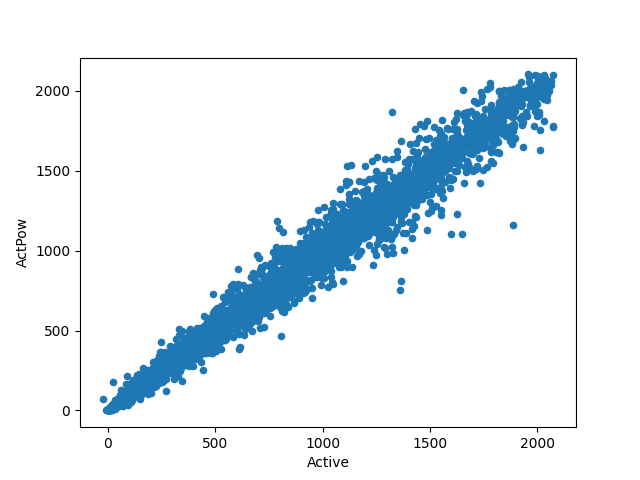

<AxesSubplot:xlabel='Active', ylabel='ActPow'>

In [13]:
## Difference between columns Active and ActivePow ? 
Npoints = 10000
ix = np.random.randint(0,Xclean.shape[0],Npoints)
Xclean[['Active','ActPow']].iloc[ix].plot.scatter(0,1)

<IPython.core.display.Javascript object>


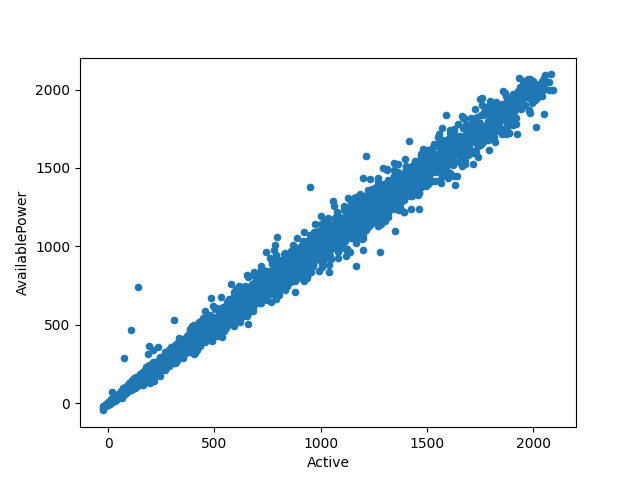

<AxesSubplot:xlabel='Active', ylabel='AvailablePower'>

In [14]:
## Difference between columns Active and AvailablePower ? 
Npoints = 10000
ix = np.random.randint(0,Xclean.shape[0],Npoints)
Xclean[['Active','AvailablePower']].iloc[ix].plot.scatter(0,1)

In [15]:
## Correlation matrix
Xclean.dropna().corr()[['Active','ActPow','AvailablePower']]

,Active,ActPow,AvailablePower
Active,1.000000,0.991674,0.996186
CosPhi,0.032807,0.035028,0.027334
GenSpeed,0.784477,0.780124,0.786233
AbsWindDirect,-0.002711,-0.003698,-0.001793
AbsWindDirectCosinus,-0.234876,-0.234625,-0.234684
AbsWindDirectSinus,0.061388,0.062663,0.060468
HydPres,-0.001006,-0.000617,-0.000241
NacelleAngleCosinus,-0.237380,-0.236805,-0.237394
NacelleAngleSinus,0.059157,0.059542,0.058736
Windspeed,0.908773,0.913557,0.904547


<IPython.core.display.Javascript object>


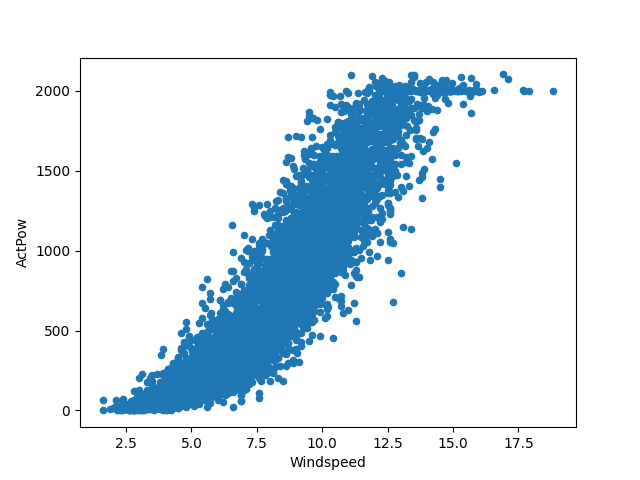

<AxesSubplot:xlabel='Windspeed', ylabel='ActPow'>

In [16]:
## Scatter diagram of power curve
Npoints = 10000
ix = np.random.randint(0,Xclean.shape[0],Npoints)
Xclean[['Windspeed','ActPow']].iloc[ix].plot.scatter(0,1)

In [17]:
## Autocorrelation of active power 
# > does it make sense to look at lagged features ? 

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(Xclean['ActPow'].iloc[:100000], lags = 60*5, missing='drop',use_vlines=False);
plt.xlabel('Lag [sec]')

ModuleNotFoundError: No module named 'statsmodels'

In [18]:
# Train a model of active power
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_validate, GridSearchCV, KFold

## Training split - includes crossvalidation
NTR = int(7* (3600*24)) # days at 1 second resolution

## A simple regression model - no lags
features = Xclean.columns.tolist()
features.remove('Active')
features.remove('AvailablePower')
features.remove('ActPow')
target = 'ActPow'
m = TransformedTargetRegressor( TransformedTargetRegressor(
        Pipeline([('normalize',StandardScaler()), #scale features
                 ('mlp', MLPRegressor(activation='relu',
                                      hidden_layer_sizes=[5,5], 
                                      max_iter=10000))],
            ),
            transformer=MinMaxScaler()), #scale target
        inverse_func=np.abs) #force positive prediction

hyperparams = [
    {'regressor__regressor__mlp__hidden_layer_sizes': 
         [[2,2],[3,3],[4,4],[5,5]],
     'regressor__regressor__mlp__activation':
         ['relu','tanh','logistic']
    }
]

clf = GridSearchCV(m, hyperparams, scoring='r2', cv=KFold(shuffle=True))

Xt = Xclean.iloc[:NTR].dropna()
%memit clf.fit(Xt[features], Xt[target])
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

peak memory: 538.80 MiB, increment: 15.47 MiB
Best parameters set found on development set:
{'regressor__regressor__mlp__activation': 'tanh', 'regressor__regressor__mlp__hidden_layer_sizes': [5, 5]}
Grid scores on development set:
0.701 (+/-0.702) for {'regressor__regressor__mlp__activation': 'relu', 'regressor__regressor__mlp__hidden_layer_sizes': [2, 2]}
0.877 (+/-0.043) for {'regressor__regressor__mlp__activation': 'relu', 'regressor__regressor__mlp__hidden_layer_sizes': [3, 3]}
0.900 (+/-0.018) for {'regressor__regressor__mlp__activation': 'relu', 'regressor__regressor__mlp__hidden_layer_sizes': [4, 4]}
0.897 (+/-0.024) for {'regressor__regressor__mlp__activation': 'relu', 'regressor__regressor__mlp__hidden_layer_sizes': [5, 5]}
0.888 (+/-0.006) for {'regressor__regressor__mlp__activation': 'tanh', 'regressor__regressor__mlp__hidden_layer_sizes': [2, 2]}
0.902 (+/-0.013) for {'regressor__regressor__mlp__activation': 'tanh', 'regressor__regressor__mlp__hidden_layer_sizes': [3, 3]}
0

In [19]:
## Train a regression model with lags
lags = list(range(1,61)) # 60 samples = 1 minute
Xclean_with_lags = Xclean.copy()
#NOTE: adding target to lagged features will improve r2 
#      but gives approximately a persistence model, 
#      where p(k) = p(k-1). 
for f in ['Windspeed']: 
    for l in lags:
        Xclean_with_lags['%s.lag%d' % (f,l)] = Xclean[f].shift(l)
features_with_lags = Xclean_with_lags.columns.tolist().copy()
features_with_lags.remove('Active')
features_with_lags.remove('AvailablePower')
features_with_lags.remove('ActPow')
        
m_with_lags = TransformedTargetRegressor( TransformedTargetRegressor(
        Pipeline([('normalize',StandardScaler()),
                 ('mlp', MLPRegressor(activation='relu',
                                      hidden_layer_sizes=[5,5], 
                                      max_iter=10000))],
            ),
            transformer=MinMaxScaler()),
        inverse_func=np.abs)

hyperparams_with_lags = [
    {'regressor__regressor__mlp__hidden_layer_sizes': 
         [[2,2],[4,4],[6,6],[8,8],[10,10]],
     'regressor__regressor__mlp__activation':
         ['relu','tanh','logistic']
    }
]

clf_with_lags = GridSearchCV(m_with_lags, hyperparams_with_lags, scoring='r2', cv=KFold(shuffle=True))

Xt_with_lags = Xclean_with_lags.iloc[:NTR].dropna()
%memit clf_with_lags.fit(Xt_with_lags[features_with_lags], Xt_with_lags[target])
print("Best parameters set found on development set:")
print(clf_with_lags.best_params_)
print("Grid scores on development set:")
means = clf_with_lags.cv_results_['mean_test_score']
stds = clf_with_lags.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_with_lags.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

peak memory: 1461.84 MiB, increment: 164.79 MiB
Best parameters set found on development set:
{'regressor__regressor__mlp__activation': 'tanh', 'regressor__regressor__mlp__hidden_layer_sizes': [8, 8]}
Grid scores on development set:
0.556 (+/-0.909) for {'regressor__regressor__mlp__activation': 'relu', 'regressor__regressor__mlp__hidden_layer_sizes': [2, 2]}
0.941 (+/-0.009) for {'regressor__regressor__mlp__activation': 'relu', 'regressor__regressor__mlp__hidden_layer_sizes': [4, 4]}
0.944 (+/-0.009) for {'regressor__regressor__mlp__activation': 'relu', 'regressor__regressor__mlp__hidden_layer_sizes': [6, 6]}
0.942 (+/-0.007) for {'regressor__regressor__mlp__activation': 'relu', 'regressor__regressor__mlp__hidden_layer_sizes': [8, 8]}
0.945 (+/-0.005) for {'regressor__regressor__mlp__activation': 'relu', 'regressor__regressor__mlp__hidden_layer_sizes': [10, 10]}
0.933 (+/-0.011) for {'regressor__regressor__mlp__activation': 'tanh', 'regressor__regressor__mlp__hidden_layer_sizes': [2, 2

<IPython.core.display.Javascript object>


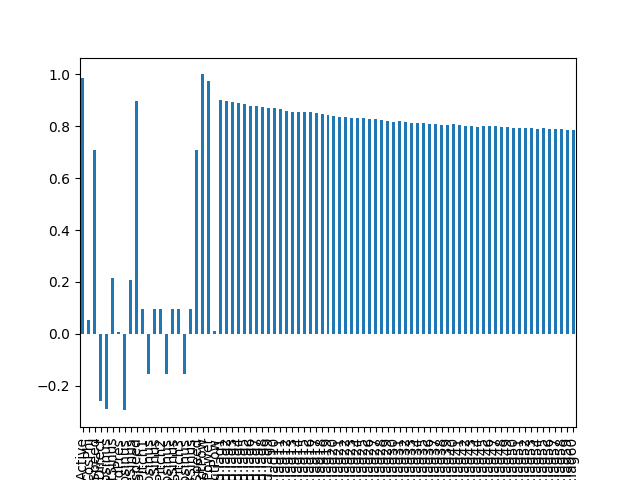

Low correlation with:
['CosPhi' 'AbsWindDirect' 'AbsWindDirectCosinus' 'AbsWindDirectSinus'
 'HydPres' 'NacelleAngleCosinus' 'NacelleAngleSinus' 'BladePitch1'
 'BladePitch1Cosinus' 'BladePitch1Sinus' 'BladePitch2'
 'BladePitch2Cosinus' 'BladePitch2Sinus' 'BladePitch3'
 'BladePitch3Cosinus' 'BladePitch3Sinus' 'ReactPow']
Top 10 features:
ActPow            1.000000
Active            0.987359
AvailablePower    0.974760
Windspeed.lag1    0.901329
Windspeed         0.899015
Windspeed.lag2    0.896914
Windspeed.lag3    0.893311
Windspeed.lag4    0.889607
Windspeed.lag5    0.885076
Windspeed.lag6    0.879963
Name: ActPow, dtype: float64


In [20]:
## Feature correlation analysis  
plt.close(-2)
plt.figure(-2)
Xclean_with_lags.iloc[:NTR].dropna().corr()[target].plot.bar()

print('Low correlation with:')
features_corr = Xclean_with_lags.iloc[:NTR].dropna().corr()[target].copy()
print(features_corr[features_corr<=0.5].index.values)

print('Top 10 features:')
print(features_corr.sort_values(ascending=False).head(10))


<IPython.core.display.Javascript object>


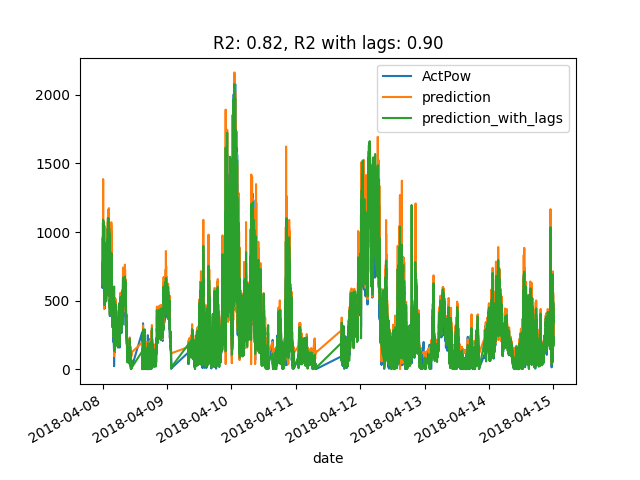

Text(0.5, 1.0, 'R2: 0.82, R2 with lags: 0.90')

In [21]:
# Test 
from sklearn.metrics import r2_score
Xtest = Xclean.iloc[NTR:].dropna()
yhat = clf.predict(Xtest[features].values)
Xtest['prediction'] = yhat

Xtest_with_lags = Xclean_with_lags[NTR:].dropna()
yhat_with_lags = clf_with_lags.predict(Xtest_with_lags[features_with_lags].values)
Xtest_with_lags['prediction_with_lags'] = yhat_with_lags
Xtest = Xtest.merge(Xtest_with_lags[['prediction_with_lags']],left_index=True,right_index=True,how='left')
Xtest[[target,'prediction','prediction_with_lags']].plot()
plt.title('R2: %.2f, R2 with lags: %.2f' % 
          (r2_score(Xtest[target].values,Xtest['prediction'].values),
           r2_score(Xtest_with_lags[target].values,Xtest_with_lags['prediction_with_lags'].values)))

In [ ]:
## Model with lagged features and feature selection step: TODO

<IPython.core.display.Javascript object>


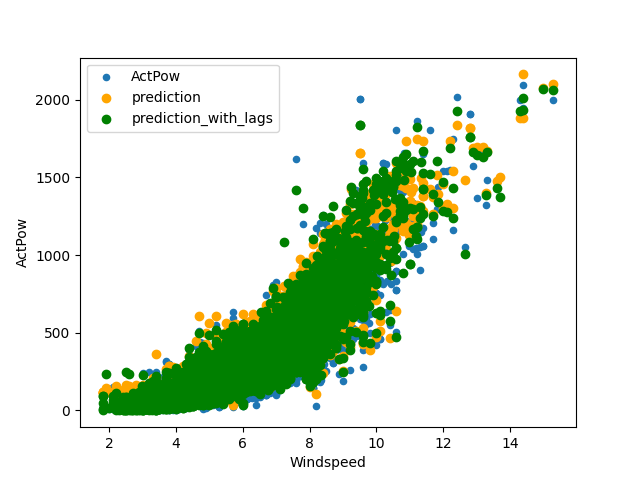

In [22]:
## Scatter diagram of power curve
Npoints = 10000
ix = np.random.randint(0,Xtest.shape[0],Npoints)
Xtest[['Windspeed','ActPow']].iloc[ix].plot.scatter(0,1)
plt.scatter(Xtest['Windspeed'].iloc[ix].values,Xtest['prediction'].iloc[ix].values,c='orange')
plt.scatter(Xtest['Windspeed'].iloc[ix].values,Xtest['prediction_with_lags'].iloc[ix].values,c='green')
plt.legend([target,'prediction','prediction_with_lags'])